In [2]:
## headings
# reference: https://github.com/eriklindernoren/Keras-GAN/blob/master/pix2pix/data_loader.py
#            https://github.com/equinor/segyio
import os
import struct
import segyio
import numpy as np


In [9]:
class Dataloader():
    def __init__(self, data_path, nt, nr, nph):
        self.data_path = data_path
        self.nt = nt
        self.nr = nr
        self.nph = nph
        
    def normaliza(self, datain):
        for batch_ii in range( datain.shape[0] ):
            for iterm_ii in range( datain.shape[-1] ):
                target = datain[batch_ii, :, :, iterm_ii]
                mind = target.min() #datain[batch_ii, :, :, iterm_ii].min()
                maxd = target.max() #datain[batch_ii, :, :, iterm_ii].max()      
                for ii in range(target.shape[0]):
                    for jj in range(target.shape[1]):
                        if target[ii, jj] > 0: 
                            target[ii,jj] = target[ii,jj] / maxd
                        if target[ii, jj] < 0:
                            target[ii,jj] = target[ii,jj] / ( 0 - mind )
                datain[batch_ii, :, :, iterm_ii] = target
    #     return datain
    
    def load_single_batch(self, batch_size=1, is_testing=False, ratio=0.5):        
        self.n_batches = int( 151 / batch_size * ratio ) #int( len(path) / batch_size * ratio )
        x_data = np.empty((batch_size, self.nt, self.nr, self.nph)) ## b-4000-300-2, vz, vx
        y_data = np.empty((batch_size, self.nt, self.nr, 1)) ## b-4000-300-2, div, curl
        i = 0
        with segyio.open(self.data_path,'r',ignore_geometry=True) as segyfile:
#             while True:
            for i in range(self.n_batches): 
                if (i + 1) * batch_size > 151 * ratio:
                    i = 0
#                 break
                for batch_i in range(batch_size):
                    for nr_i in range(self.nr):
#                         with segyio.open(self.data_path,'r',ignore_geometry=True) as segyfile:
                            segyfile.mmap()
                            y_data[batch_i,:,nr_i,0] = \
                            segyfile.trace[i*batch_size*4*self.nr + batch_i * 4 * self.nr + nr_i * 4 + 0]
                            x_data[batch_i,:,nr_i,0] = \
                            segyfile.trace[i*batch_size*4*self.nr + batch_i * 4 * self.nr + nr_i * 4 + 1]
                            x_data[batch_i,:,nr_i,1] = \
                            segyfile.trace[i*batch_size*4*self.nr + batch_i * 4 * self.nr + nr_i * 4 + 2]
                            x_data[batch_i,:,nr_i,2] = \
                            segyfile.trace[i*batch_size*4*self.nr + batch_i * 4 * self.nr + nr_i * 4 + 3]                 
                self.normaliza(x_data)
                self.normaliza(y_data)
                yield x_data, y_data
                i = i + 1

In [10]:
# data_path = "/media/wywdisk/VSPdata/data/haveinvx/layer2_haveinvx"
# data_path = "/home/wyw/data/MKDATA/mkvspdata/E28093/E-layer4"
# data_path = '/media/wywdisk/VSPdata/data/realData/SEAM_I_Walkaway_VSP/SEAM_Well1VSP_Shots23900.sgy'
data_path = '/home/wyw/data/SEAM_I_walkaway_vsp_s23900/SEAM_Well1VSP_Shots23900.sgy'
my_data_loader = Dataloader(data_path, 2001, 467, 3)

In [11]:
# my_data_loader.load_batch(batch_size=1, is_testing=False, ratio=0.001)

In [13]:
for batch_i, (x_data, y_data) in enumerate(my_data_loader.load_single_batch(batch_size=1, is_testing=False, ratio=0.01)):
    print(batch_i)
#     print(x_data.shape, y_data.shape )
#     print(x_data,y_data)
#     a1 = y_predict
#     print("Information of a1 :")
    print("The shape of a1   :",x_data.shape)
    print("The range        : ", [x_data[-1,:,:,0].min(),x_data[-1,:,:,0].max()])
    print("The range        : ", [x_data[-1,:,:,1].min(),x_data[-1,:,:,1].max()])
    print("The range        : ", [x_data[-1,:,:,2].min(),x_data[-1,:,:,2].max()])
    print("The range        : ", [y_data[-1,:,:,0].min(),y_data[-1,:,:,0].max()])

0
The shape of a1   : (1, 2001, 467, 3)
The range        :  [-1.0, 1.0]
The range        :  [-1.0, 1.0]
The range        :  [-1.0, 1.0]
The range        :  [-1.0, 1.0]


In [14]:
def get_percentile(data, perc):
    ## data shape, [0,:,:,0]
    dd1, dd2 = np.shape(data)
    tmp = np.zeros_like(data)
    for idd2 in range(dd2):
        tmp[:,idd2] = np.percentile(data[:,idd2], 99)
    return tmp

In [15]:
## plot y_predict
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

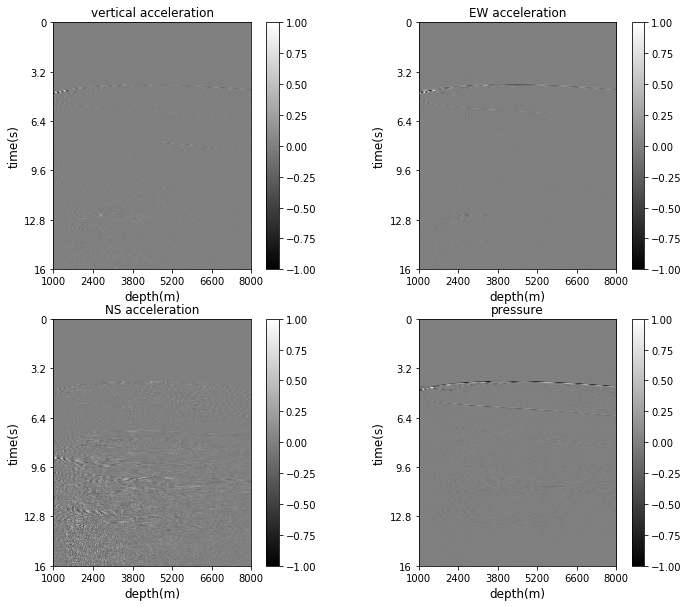

In [34]:
# ## plot y_predict
# import matplotlib as cm
# import matplotlib.pyplot as plt
# from matplotlib.ticker import MultipleLocator
lines = 2
cols = 2
forts = 12
ss1 = 400
ss2 = 500
value_limit = 1#1e-20

x_libs = [0,1000,1000+1400,1000+1400*2, 1000+1400*3, 1000+1400*4,8000]#[0,0, 500, 1000, 1500, 2000]#np.linspace(0,1500,4)#[0, 500, 1000, 1500]
y_libs = [0,3.2, 6.4, 9.6, 12.8,16]#8*np.linspace(0,2,6, dtype=float)#[0,0.4, 0.8, 1.2, 1.6, 2]

fig, axs = plt.subplots(1,2,figsize=(12, 10), sharey=True)

# obj = 'y_predict'
# im = plt.imshow(eval(obj)[0,:,:,1], extent=[0, 512, 512,0])
# plt.colorbar(im)

# ax1 = plt.subplot(131)
ax1 = plt.subplot(lines,cols,1)
obj = 'x_data'
target_data = eval(obj)[0,:,:,0]
value_limit=np.max( target_data ) / 10
# print(obj, ": ", eval(obj).shape, "\t", [eval(obj).min(), eval(obj).max()] )
# target_data = get_percentile(eval(obj)[0,:,:,0], 99)
# im = plt.imshow(target_data, extent=[0, ss1, ss2,0],vmin=-value_limit, vmax=value_limit)
im = plt.imshow(eval(obj)[0,:,:,0], extent=[0, ss1, ss2,0],vmin=-value_limit, vmax=value_limit,cmap="gray")
plt.colorbar(im)
# plt.title("The elastic z component of VSP data", fontsize=forts);
plt.title("vertical acceleration", fontsize=forts);
plt.xlabel('depth(m)', fontsize=forts);
plt.ylabel('time(s)', fontsize=forts);
ax1.xaxis.set_major_locator(MultipleLocator(80))
ax1.xaxis.set(ticklabels=x_libs)#[0,300,600, 900, 1200, 1500]);
ax1.yaxis.set(ticklabels=y_libs)#[0,0.4, 0.8, 1.2, 1.6, 2]);
plt.setp(ax1.get_xticklabels(), fontsize=10);
# plt.tight_layout()

# ax1 = plt.subplot(131)
ax2 = plt.subplot(lines,cols,2)
obj = 'x_data'
target_data = eval(obj)[0,:,:,0]
value_limit=np.max( target_data ) / 10
# print(obj, ": ", eval(obj).shape, "\t", [eval(obj).min(), eval(obj).max()] )
im = plt.imshow(eval(obj)[0,:,:,1], extent=[0, ss1, ss2,0],vmin=-value_limit, vmax=value_limit,cmap="gray")
plt.colorbar(im)
# plt.title("The elastic z component of VSP data", fontsize=forts);
plt.title("EW acceleration", fontsize=forts);
plt.xlabel('depth(m)', fontsize=forts);
plt.ylabel('time(s)', fontsize=forts);
# ax1 = fig.add_subplot(131)
ax2.xaxis.set_major_locator(MultipleLocator(80))
ax2.xaxis.set(ticklabels=x_libs)#[0,300,600, 900, 1200, 1500]);
ax2.yaxis.set(ticklabels=y_libs)#[0,0.4, 0.8, 1.2, 1.6, 2]);
plt.setp(ax2.get_xticklabels(), fontsize=10);
# plt.tight_layout()

# ax1 = plt.subplot(131)
ax3 = plt.subplot(lines,cols,3)
obj = 'x_data'
target_data = eval(obj)[0,:,:,0]
value_limit=np.max( target_data ) / 10
# print(obj, ": ", eval(obj).shape, "\t", [eval(obj).min(), eval(obj).max()] )
im = plt.imshow(eval(obj)[0,:,:,2], extent=[0, ss1, ss2,0],vmin=-value_limit, vmax=value_limit,cmap="gray")
plt.colorbar(im)
# plt.title("The elastic z component of VSP data", fontsize=forts);
plt.title("NS acceleration", fontsize=forts);
plt.xlabel('depth(m)', fontsize=forts);
plt.ylabel('time(s)', fontsize=forts);
# ax1 = fig.add_subplot(131)
ax3.xaxis.set_major_locator(MultipleLocator(80))
ax3.xaxis.set(ticklabels=x_libs)#[0,300,600, 900, 1200, 1500]);
ax3.yaxis.set(ticklabels=y_libs)#[0,0.4, 0.8, 1.2, 1.6, 2]);
plt.setp(ax3.get_xticklabels(), fontsize=10);
# plt.tight_layout()

# ax1 = plt.subplot(131)
ax4 = plt.subplot(lines,cols,4)
obj = 'y_data'
target_data = eval(obj)[0,:,:,0]
value_limit=np.max( target_data ) / 10
# print(obj, ": ", eval(obj).shape, "\t", [eval(obj).min(), eval(obj).max()] )
im = plt.imshow(eval(obj)[0,:,:,0], extent=[0, ss1, ss2,0],vmin=-value_limit, vmax=value_limit,cmap="gray")
plt.colorbar(im)
# plt.title("The elastic z component of VSP data", fontsize=forts);
plt.title("pressure", fontsize=forts);
plt.xlabel('depth(m)', fontsize=forts);
plt.ylabel('time(s)', fontsize=forts);
# ax1 = fig.add_subplot(131)
ax4.xaxis.set_major_locator(MultipleLocator(80))
ax4.xaxis.set(ticklabels=x_libs)#[0,300,600, 900, 1200, 1500]);
ax4.yaxis.set(ticklabels=y_libs)#[0,0.4, 0.8, 1.2, 1.6, 2]);
plt.setp(ax4.get_xticklabels(), fontsize=10);
# plt.tight_layout()



In [ ]:
plt.figure(figsize=(10,10))
ss1 = 300#467*3; 
ss2 = 400#2001
obj = 'y_data'
target_data = eval(obj)[0,:,:,0]
value_limit=np.max( target_data ) * 0.06 #/ 10
# print(obj, ": ", eval(obj).shape, "\t", [eval(obj).min(), eval(obj).max()] )
im = plt.imshow(target_data, extent=[0, ss1, ss2,0],vmin=-value_limit, vmax=value_limit, cmap="gray")
plt.colorbar(im);


In [ ]:
plt.figure(figsize=(10,10))
obj = 'x_data'
target_data = eval(obj)[0,:,:,0]
value_limit=np.max( target_data ) *0.05 #/ 10
# print(obj, ": ", eval(obj).shape, "\t", [eval(obj).min(), eval(obj).max()] )
im = plt.imshow(target_data, extent=[0, ss1, ss2,0],vmin=-value_limit, vmax=value_limit, cmap="gray")
plt.colorbar(im);

